# Problem Statement:

 ompanies in the USA are open to hiring highly skilled people both locally and internationally.

The Immigration and Nationality Act (INA) of the United States allows foreign workers to come to the country to work on a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring all the safeguards mentioned in the act. Office of Foreign Labor Certification (OFLC) administers this act.

The OFLC (Office of Foreign Labor Certification) processed millions of applications for different positions for temporary and permanent labor certifications. There is a percentage increase in the number of applications as compared to previous years. The process of reviewing every case is becoming a tedious task as the number of applicants increases every year. With an increasing number of applicants each year, a machine learning-based solution that can assist in shortlisting candidates with a higher chance of VISA approval is required.

 EasyVisa has been hired by OFLC to provide data-driven solutions. As a data scientist at EasyVisa, you must analyze the data provided and, using a classification model, make the visa approval process easier.

 


## Dataset Description:

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full-Time Position; N = Part-Time Position
* case_status: Flag indicating if the Visa was certified or denied

## Data Pre-processing

#### Import all necessary libraries


In [27]:
#!pip install imblearn 
#!pip install delayed
#!pip install --upgrade sklearn
#import sklearn
#print(f' sklearn version is {sklearn.__version__}')


 sklearn version is 0.22.1


In [2]:
# Packages to process data
import pandas as pd
import numpy as np
import datetime
import time

# Filter and ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Packages for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for data pre-processing
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# sagemaker library 
import boto3, sagemaker,os
from sagemaker import get_execution_role
from sagemaker import TrainingInput
from sagemaker.model import Model
from sagemaker.serializers import CSVSerializer

In [4]:
#library for tuning hyperparameter. 
from sagemaker.tuner import ( IntegerParameter,
                             CategoricalParameter,
                             ContinuousParameter,
                             HyperparameterTuner,
                            )
from time import gmtime, strftime

#### Create the S3 bucket and read the dataset from S3 Bucket

In [9]:
#define the role, bucker name and create a bucket,# create a session where the model will be  build. 
inputfile_name='EasyVisa.csv'
#___________________________________________________
# define the IAM role 
role=get_execution_role()
# defind bucket name, session , region
bucket_name='easy-visa'
session=sagemaker.Session()
region_name= boto3.session.Session().region_name
print("Region = {}".format(region_name))
#-----------------------------------------------
# connect to s3 and create the bucket
s3=boto3.client('s3')
sm_boto3 = boto3.client('sagemaker')
s3.create_bucket(Bucket=bucket_name)

Region = us-east-1


{'ResponseMetadata': {'RequestId': 'ACNBW7FZC0Y3WHAP',
  'HostId': '82JbFXq9iPvZt4dmWKbdie4tjNpEI+wqYEvj5Y3p5dfWlLv+SaDKrfXnaNs4XdEV+HSukbvPDlReu5nt+PwgLA==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '82JbFXq9iPvZt4dmWKbdie4tjNpEI+wqYEvj5Y3p5dfWlLv+SaDKrfXnaNs4XdEV+HSukbvPDlReu5nt+PwgLA==',
   'x-amz-request-id': 'ACNBW7FZC0Y3WHAP',
   'date': 'Fri, 10 Feb 2023 16:49:52 GMT',
   'location': '/easy-visa',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/easy-visa'}

#### Read data from S3. (Upload the data into S3 Bucket manually and with the help of code read the data from the S3 Bucket)
Note: 
* Keep the target column at first place in the dataframe
* Drop the column 'case_id'
* Replace the value of Denied with 0 and Certified with 1 in the case_status column
* Apply the lable encoding

In [155]:
#upload the csv file to s3 from sagemaker
s3.upload_file(Bucket=bucket_name,Filename=inputfile_name,Key=inputfile_name)

In [156]:
# reading data from s3 into pandas 
df=pd.read_csv(s3.get_object(Bucket=bucket_name,Key=inputfile_name).get('Body'))

In [157]:
#### EDA

In [158]:
# shift target column to fisrt column    
case_status=df.pop('case_status')
df.insert(0,'case_status',case_status)
# drop case id becuaes it not important 
df.drop('case_id',axis=1,inplace=True)

In [193]:
# subclasses of categorical features. 
df.select_dtypes('object').apply(lambda x:print(f'{x.name}:{x.nunique()}\n{x.value_counts()}\n'));

case_status:2
Certified    17018
Denied        8462
Name: case_status, dtype: int64

continent:6
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: continent, dtype: int64

education_of_employee:4
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: education_of_employee, dtype: int64

has_job_experience:2
Y    14802
N    10678
Name: has_job_experience, dtype: int64

requires_job_training:2
N    22525
Y     2955
Name: requires_job_training, dtype: int64

region_of_employment:5
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: region_of_employment, dtype: int64

unit_of_wage:4
Year     22962
Hour      2157
Week       272
Month       89
Name: unit_of_wage, dtype: int64

full_time_position:2
Y    22773
N     2707
Name: full_time_position, dtype: int64



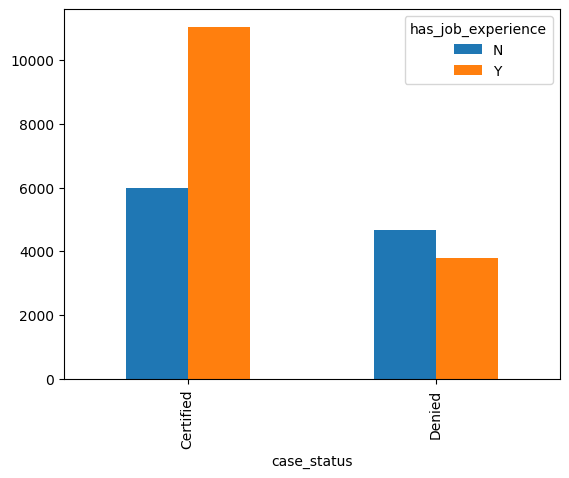

In [160]:
case_status=pd.pivot_table(df,index='case_status',columns='has_job_experience',values='no_of_employees',aggfunc='count')
case_status.plot.bar()
plt.show()


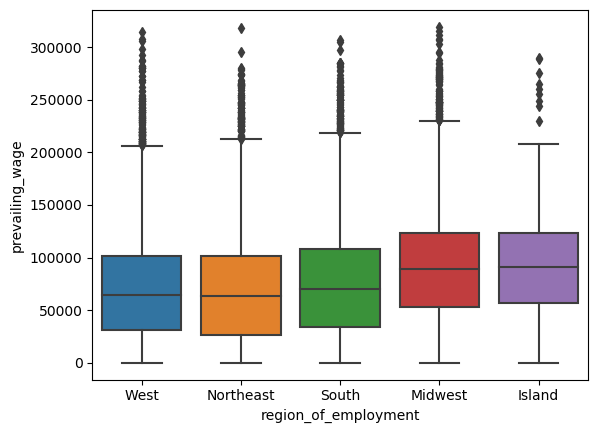

In [161]:
sns.boxplot(data=df,x='region_of_employment',y='prevailing_wage')
plt.show()

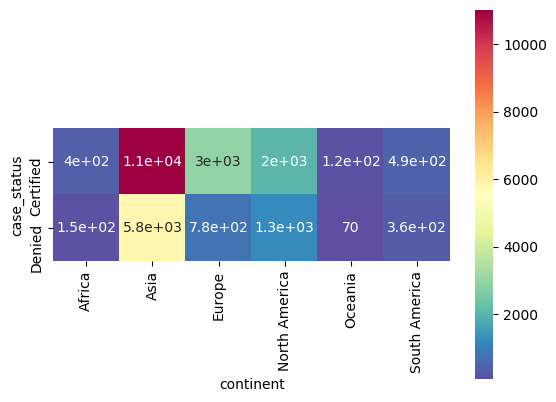

In [192]:
case_status=pd.pivot_table(df,index='case_status',columns='continent',values='no_of_employees',aggfunc='count')
sns.heatmap(data=case_status,annot=True,square=True,cmap='Spectral_r')
plt.show()


region_of_employment  Island  Midwest  Northeast  South  West
case_status                                                  
Certified                226     3253       4526   4913  4100
Denied                   149     1054       2669   2104  2486


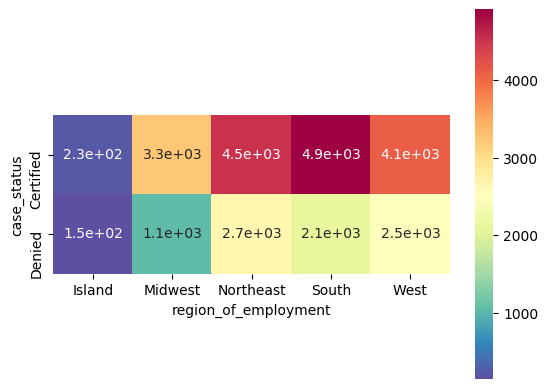

In [191]:
case_status=pd.pivot_table(df,index='case_status',columns='region_of_employment',values='no_of_employees',aggfunc='count')
print(case_status)
sns.heatmap(data=case_status,annot=True,square=True,cmap='Spectral_r')
plt.show()

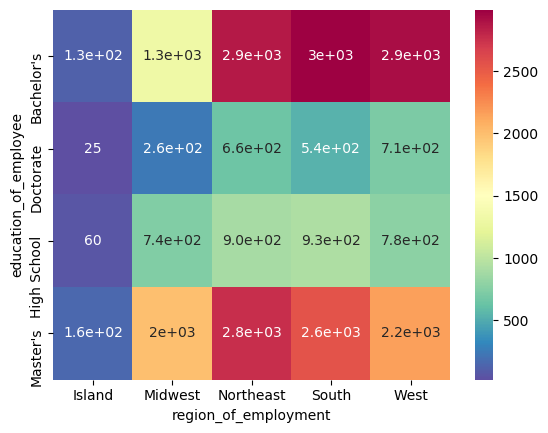

In [167]:
education_of_employee=pd.pivot_table(df,index='education_of_employee',columns='region_of_employment',values='case_status',aggfunc='count')
education_of_employee
sns.heatmap(education_of_employee,cmap='Spectral_r',annot=True)
plt.show()

In [19]:
# Renaming the the target 'case statues' feature classes. 
df['case_status'].replace( {'Denied':0, 'Certified': 1},inplace=True)


In [86]:
df['case_status'].value_counts()
ratio=df['case_status'].value_counts()[0]/df['case_status'].value_counts()[1]
print(f'negative/positove = {ratio}')

negative/positove = 0.49723821835703375


In [23]:
# Labeling the categorical values 
cat_col=['continent','has_job_experience','full_time_position','region_of_employment','education_of_employee','unit_of_wage','requires_job_training']
LE=LabelEncoder()
for col in cat_col:
    df[col]=LE.fit_transform(df[col])

In [21]:
# applying one hot encoding 
oh= OneHotEncoder(sparse=False,drop='first')
one_hot_encoded=oh.fit_transform(df[cat_col])

#df1 = pd.concat([df,one_hot_encoded],axis=1).drop(columns=cat_col)
df1=pd.concat([df.drop(cat_col,axis=1),pd.DataFrame(one_hot_encoded,columns=oh.get_feature_names(cat_col).tolist()),],axis=1)

In [22]:
df1.head(2)

,case_status,no_of_employees,yr_of_estab,prevailing_wage,continent_1,continent_2,continent_3,continent_4,continent_5,has_job_experience_1,...,region_of_employment_2,region_of_employment_3,region_of_employment_4,education_of_employee_1,education_of_employee_2,education_of_employee_3,unit_of_wage_1,unit_of_wage_2,unit_of_wage_3,requires_job_training_1
0,0,14513,2007,592.2029,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,2412,2002,83425.6500,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Split data and upload back to S3

In [27]:
# split the data into train and validation and save it localy
train,validation=train_test_split(df1,test_size=0.2,random_state=1)
# save teh train validation to local sagemker 
train.to_csv('train.csv',index=0)
validation.to_csv('validation.csv',index=0)

#### Upload into S3 (checkpoint)

Let's checkpoint the train and validation datasets into the S3 Bucket, so we can fallback in case we need them again

In [28]:
# define the directory where the processed data will be saved inside the bucket. 
prefix_pro='processed-data'
trainpath=session.upload_data( path="train.csv", bucket=bucket_name, key_prefix=prefix_pro)                                                       
valpath=session.upload_data( path="validation.csv", bucket=bucket_name, key_prefix=prefix_pro)                                                      

In [29]:
print(trainpath)
print(valpath)

s3://easy-visa/processed-data/train.csv
s3://easy-visa/processed-data/validation.csv


## Training, Tuning and Deploying the model

### Model Training

#### Get the container image for Xgboost

In [30]:
#the xgboost in the image contaier and finding the model version
model_uris='xgboost'
image_version="1.5-1"
# define the contaier were the training will happed .
container=sagemaker.estimator.image_uris.retrieve(framework=model_uris,region='us-east-1' ,version=image_version)

#### Set the training configuration

In [31]:
# seting teh inputs from s3
s3_input_train=TrainingInput(s3_data=f"s3://{bucket_name}/{prefix_pro}/train",content_type='csv')
s3_input_val=TrainingInput(s3_data=f"s3://{bucket_name}/{prefix_pro}/validation",content_type='csv')


#### Train Classification Model (inbuilt XG-Boost model) using the data

In [32]:
train_prefix='xgb_model'
xgb=sagemaker.estimator.Estimator(
    
    container,
    role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path="s3://{}/{}/output".format(bucket_name,train_prefix),
    sagemaker_session=session,
)

In [44]:
# set some hyperparameter for the base xgboost model 
def to_dic(dic_param):
    for key,value in dic_param.items():
        print(''.join(''),key, '=' ,value,',')
hyp1={ 'verbosity':0,'objective':'binary:logistic','num_round':100}
print(to_dic(hyp1))
xgb.set_hyperparameters(verbosity = 0 ,
 objective = 'binary:logistic' ,
 num_round = 100,
          scale_pos_weight = 0.5 )


 verbosity = 0 ,
 objective = binary:logistic ,
 num_round = 100 ,
None


In [49]:
#fit the model using the inputs 

In [45]:
xgb.fit({'train':s3_input_train,'validation':s3_input_val})
    
    

2023-02-10 17:12:10 Starting - Starting the training job...
2023-02-10 17:12:35 Starting - Preparing the instances for trainingProfilerReport-1676049130: InProgress
.........
2023-02-10 17:13:54 Downloading - Downloading input data...
2023-02-10 17:14:34 Training - Downloading the training image...
2023-02-10 17:14:58 Training - Training image download completed. Training in progress..[2023-02-10 17:15:10.388 ip-10-0-140-253.ec2.internal:8 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-10:17:15:10:INFO] Imported framework sagemaker_xgboost_container.training
[2023-02-10:17:15:10:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2023-02-10:17:15:10:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-10:17:15:10:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-02-10:17:15:10:INFO] Determined delimiter of CSV input is ','
[2023-02-10:17:15:10:INFO] Determined delimiter of CSV input is ','
[2023-02-10:

#### Deploy the model

In [46]:
# deploty the trained model 
xgb_predictor=xgb.deploy(
            initial_instance_count=1,
           instance_type='ml.m4.xlarge',
           serializer=CSVSerializer(),
           
)

----------!

#### Save the predictions

In [47]:
# function sereialize the input into smaller arrays and make a predictions, 
#saveing the prediction values in data base with the real values . 
def predict(model,data,rows=500):
    split_array=np.array_split(data,int(data.shape[0]/float(rows)+1))
    prediction=""
    for array in split_array:
        prediction="".join([prediction,model.predict(array).decode('utf-8')])
    return prediction.split("\n")[:-1]
predictions=predict(xgb_predictor,validation.drop('case_status',axis=1).to_numpy())

In [48]:
prediction=np.array([float(num) for num in predictions])
print(prediction)

[0.74695969 0.80427605 0.52410513 ... 0.72941768 0.94687051 0.75559515]


In [49]:
# prepare a dataframe to evaluate the results. 
columns=np.round(prediction,0)
predictions = pd.DataFrame(columns)
test_y = validation['case_status']
actual = test_y
test_x = validation.drop(columns=['case_status'],axis=1)
predictions.columns =['class_pred']
# Concatenate them into a single dataframe
output = pd.concat([test_x.reset_index(drop=True),actual.reset_index(drop=True),predictions.reset_index(drop=True)],axis=1)
output['class_pred'] = output['class_pred'].astype(int)
output.head()

,no_of_employees,yr_of_estab,prevailing_wage,continent_1,continent_2,continent_3,continent_4,continent_5,has_job_experience_1,full_time_position_1,...,region_of_employment_4,education_of_employee_1,education_of_employee_2,education_of_employee_3,unit_of_wage_1,unit_of_wage_2,unit_of_wage_3,requires_job_training_1,case_status,class_pred
0,567,1992,26842.9100,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
1,619,1938,66419.9800,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
2,2635,2005,887.2921,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
3,3184,1986,49435.8000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1
4,4681,1928,49865.1900,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1


#### Evaluate the model using performance metrics

In [50]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report

Confusion Matrix

In [51]:
confusion=confusion_matrix(output['case_status'],output['class_pred'])
confusion 

array([[ 790,  842],
       [ 506, 2958]])

In [52]:
# true pose and true negative, false negative false positive  
true_pos=confusion[0][0]
false_pos=confusion[0][1]
false_neg=confusion[1][0]
true_neg=confusion[1][1]

**Accuracy**: 


In [53]:
accuracy=(true_pos + true_neg)/(true_pos+false_pos+false_neg+true_neg)
accuracy

0.7354788069073783

**Precision**: 


In [54]:
precision=(true_pos)/(true_pos+false_pos)
precision

0.4840686274509804

**Recall**:


In [55]:
#recall_score=recall_score(output['case_status'],output['class_pred'])
recall=(true_pos)/(true_pos+false_neg)
recall

0.6095679012345679

**F1 score**:


In [56]:
#f1_score
f1=(2*precision*recall)/(precision+recall)
f1

0.5396174863387979

In [57]:
base_model=np.array([accuracy,precision,recall,f1])
print(base_model)

[0.73547881 0.48406863 0.6095679  0.53961749]


### Model Tuning

**Hyper-parameter Tuning** is the art of figuring out what works best for your model - performing well statistically and aligning with your business context & needs

In [ ]:
# we choose F1 as a metric for the model, becasue we need to balance both recalland pression. we need to reduce the false nagative and false positiove. 


#### Define the parameter space & train the model

Each model is build on a different algorithm, and hence the hyper-parameters may vary. 

In [58]:
## input train and validation 
bucket=bucket_name
s3train = TrainingInput(
    s3_data="s3://{}/{}/train.csv".format(bucket, prefix_pro), content_type="csv")

s3validation = TrainingInput(
    s3_data="s3://{}/{}/validation.csv".format(bucket, prefix_pro), content_type="csv")


# define the hyperparameter 

hyperparameter_ranges={
                    "eta":ContinuousParameter(0,0.9,scaling_type="Auto"), 
                    "max_depth":IntegerParameter(2,10),
                    "subsample":ContinuousParameter(0.3,1),
                    'alpha': ContinuousParameter(0, 10,scaling_type="Linear"),
                    "lambda": ContinuousParameter(0.01, 10, scaling_type="Linear"),
                    'gamma':ContinuousParameter(0,10 ),
                    'min_child_weight': ContinuousParameter(0, 5),
   
}
                     
 
# Create an optimizer instance 
tuner = HyperparameterTuner( 
    estimator=xgb, # model training instance
    hyperparameter_ranges=hyperparameter_ranges, # parameter space
    base_tuning_job_name="xgboost-tuning", # Prefix of the tuning job
    objective_type="Maximize", 
       max_jobs=10,
    max_parallel_jobs=5,
     objective_metric_name="validation:f1",
   
    metric_definitions=[
        {"Name": "validation:f1", "Regex": ".*\[[0-9]+\].*#011validation-f1:([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*"},
        {"Name": "train:f1", "Regex": "	.*\[[0-9]+\].*#011train-f1:([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*"},# search logs on cloudwatch
    ],
    strategy= 'Bayesian',
    
)                 

In [59]:
 #{"train": s3train, "validation": s3validation},
tuner.fit({"train": s3train,"validation":s3validation}, include_cls_metadata=False,wait=True,
    job_name="xgb-tuning-" + strftime("%Y%m%d-%H-%M-%S", gmtime()),logs=True,
)

..............................................................................!


In [61]:
# using sagemaker to check the hyper tuning job performance. 
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

In [62]:
# convert the tuning model results to dataframe and sorting based on the final object values. 
results = tuner.analytics().dataframe()
results.sort_values(by='FinalObjectiveValue',ascending=False)

,alpha,eta,gamma,lambda,max_depth,min_child_weight,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
6,6.592625,0.238201,6.410164,4.707249,8.0,1.488435,0.914300,xgb-tuning-20230210-17-52-20-004-f1cba8c3,Completed,0.69433,2023-02-10 17:54:27+00:00,2023-02-10 17:56:15+00:00,108.0
7,4.105448,0.670518,8.738690,3.520992,10.0,3.581332,0.563094,xgb-tuning-20230210-17-52-20-003-8a333df4,Completed,0.69360,2023-02-10 17:54:04+00:00,2023-02-10 17:55:52+00:00,108.0
1,6.639240,0.136881,5.241214,3.571540,8.0,1.900164,0.912782,xgb-tuning-20230210-17-52-20-009-981d5a42,Completed,0.69344,2023-02-10 17:56:48+00:00,2023-02-10 17:57:26+00:00,38.0
9,1.237635,0.727635,9.018027,4.964044,10.0,0.661026,0.725597,xgb-tuning-20230210-17-52-20-001-71fff89c,Completed,0.69183,2023-02-10 17:54:33+00:00,2023-02-10 17:56:26+00:00,113.0
5,7.377655,0.515698,5.934360,1.326187,5.0,4.186140,0.450955,xgb-tuning-20230210-17-52-20-005-e96c7568,Completed,0.69041,2023-02-10 17:54:37+00:00,2023-02-10 17:56:44+00:00,127.0
0,6.403197,0.370121,7.431856,6.268758,8.0,1.625142,0.787864,xgb-tuning-20230210-17-52-20-010-b8b62dc3,Completed,0.68943,2023-02-10 17:57:00+00:00,2023-02-10 17:58:40+00:00,100.0
8,2.275326,0.713760,6.305467,6.411131,5.0,4.330617,0.858874,xgb-tuning-20230210-17-52-20-002-24664479,Completed,0.68846,2023-02-10 17:54:23+00:00,2023-02-10 17:56:16+00:00,113.0
3,4.675147,0.531365,6.296973,5.525788,9.0,0.120620,0.764713,xgb-tuning-20230210-17-52-20-007-4d9aacd7,Completed,0.68723,2023-02-10 17:56:35+00:00,2023-02-10 17:57:18+00:00,43.0
2,8.688197,0.694573,2.712939,7.612774,10.0,3.251525,0.503768,xgb-tuning-20230210-17-52-20-008-6b14d2f4,Completed,0.68276,2023-02-10 17:56:38+00:00,2023-02-10 17:57:15+00:00,37.0
4,1.127740,0.437483,0.218608,3.618339,10.0,1.687255,0.759437,xgb-tuning-20230210-17-52-20-006-7f9a1129,Completed,0.65496,2023-02-10 17:56:34+00:00,2023-02-10 17:57:17+00:00,43.0


In [63]:
tuning_job_result=boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)
if tuning_job_result.get("BestTrainingJob", None):
    dic_param=tuning_job_result["BestTrainingJob"]['TunedHyperParameters']
    print("Best model found so far:")
    print(tuning_job_result["BestTrainingJob"]['TunedHyperParameters'])


Best model found so far:
{'alpha': '6.592624724832314', 'eta': '0.23820098017812882', 'gamma': '6.410164036671141', 'lambda': '4.707248702029074', 'max_depth': '8', 'min_child_weight': '1.4884349694439298', 'subsample': '0.9142998169718173'}


In [75]:
#auto input for the hyperparameter using function to dic
#hyp1.update(tuning_job_result["BestTrainingJob"]['TunedHyperParameters'])
hypers=to_dic(hyp1)       
hypers

 verbosity = 0 ,
 objective = binary:logistic ,
 num_round = 100 ,
 alpha = 6.592624724832314 ,
 eta = 0.23820098017812882 ,
 gamma = 6.410164036671141 ,
 lambda = 4.707248702029074 ,
 max_depth = 8 ,
 min_child_weight = 1.4884349694439298 ,
 subsample = 0.9142998169718173 ,


In [77]:
# rebuild the model 
train_prefix='xgb_tuned_model'
tuned_xgb=sagemaker.estimator.Estimator(
    
    container,
    role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path="s3://{}/{}/output".format(bucket_name,train_prefix),
    sagemaker_session=session,
)
# set some hyperparameter for the base xgboost model 
tuned_xgb.set_hyperparameters(
 verbosity = 0 ,
 objective = 'binary:logistic' ,
 num_round = 100 ,
 alpha = 6 ,
 eta = 0.23 ,
 gamma = 6.4 ,
 max_depth = 8 ,
 min_child_weight = 1.4 ,
 subsample = 0.9,)
tuned_xgb.fit({'train':s3_input_train,'validation':s3_input_val})


2023-02-10 18:10:50 Starting - Starting the training job...ProfilerReport-1676052650: InProgress
...
2023-02-10 18:11:23 Starting - Preparing the instances for training......
2023-02-10 18:12:40 Downloading - Downloading input data...
2023-02-10 18:13:19 Training - Downloading the training image...
2023-02-10 18:13:45 Training - Training image download completed. Training in progress...[2023-02-10 18:14:02.330 ip-10-2-212-50.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-10:18:14:02:INFO] Imported framework sagemaker_xgboost_container.training
[2023-02-10:18:14:02:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2023-02-10:18:14:02:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-10:18:14:02:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-02-10:18:14:02:INFO] Determined delimiter of CSV input is ','
[2023-02-10:18:14:02:INFO] Determined delimiter of CSV input is ','
[2023-02-10:

### Deploy the tuned model

In [87]:
tuned_xgb_predictor=tuned_xgb.deploy(instance_type="ml.m5.xlarge", initial_instance_count=1)

------!

In [125]:
# prediction 
tuned_xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()
def predict(data,rows=200):
    split_array=np.array_split(data,int(data.shape[0]/float(rows)+1))
    prediction=""
    for array in split_array:
        prediction="".join([prediction,tuned_xgb_predictor.predict(array).decode('utf-8')])
    return prediction.split("\n")[:-1]
predictions=predict(validation.drop('case_status',axis=1).values)
#print(predictions)


#### Save the predictions

In [126]:
columns=np.round(prediction,0)
predictions = pd.DataFrame(columns)
test_y = validation['case_status']
actual = test_y
test_x = validation.drop(columns=['case_status'],axis=1)
predictions.columns =['class_pred']
# Concatenate them into a single dataframe
output_tune= pd.concat([test_x.reset_index(drop=True),actual.reset_index(drop=True),predictions.reset_index(drop=True)],axis=1)
output_tune['class_pred'] = output['class_pred'].astype(int)
output_tune.head()

,no_of_employees,yr_of_estab,prevailing_wage,continent_1,continent_2,continent_3,continent_4,continent_5,has_job_experience_1,full_time_position_1,...,region_of_employment_4,education_of_employee_1,education_of_employee_2,education_of_employee_3,unit_of_wage_1,unit_of_wage_2,unit_of_wage_3,requires_job_training_1,case_status,class_pred
0,567,1992,26842.9100,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
1,619,1938,66419.9800,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
2,2635,2005,887.2921,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
3,3184,1986,49435.8000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1
4,4681,1928,49865.1900,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1


#### Evaluate the tuned model (compare performace with baseline model)

Confusion Matrix

In [127]:
# Evaluate the model using a confusion matrix
matrix = confusion_matrix(output_tune['case_status'], output_tune['class_pred'])
# Display matrix
print(matrix)
true_neg = matrix[0][0]
fals_pos = matrix[0][1]
fals_neg = matrix[1][0]
true_pos = matrix[1][1]

[[ 790  842]
 [ 506 2958]]


Calulate all performance metrics - after tuning


In [128]:
accuracy_tuned = (true_pos + true_neg) / (true_pos + fals_pos + fals_neg + true_neg)
precision_tuned = true_pos / (true_pos + fals_pos)
recall_tuned = true_pos / (true_pos + fals_neg)
f1_tuned=(2*precision_tuned*recall_tuned)/(precision_tuned+recall_tuned)

In [133]:
# Display performance metrics before & after tuning, and the % increment achieved
print("The improvment of the performance metrics  with hyperparameters tuning")
print("accuracy:  before:{:0.2f}, after:{:0.2f}, %increment:{:0.2f}%".
      format(accuracy,accuracy_tuned,(accuracy_tuned-accuracy)*100))
print("precision: before:{:0.2f}, after:{:0.2f}, %increment:{:0.2f}%".
      format(precision,precision_tuned,(precision_tuned-precision)*100))
print("recall:    before:{:0.2f}, after:{:0.2f}, %increment:{:0.2f}%".
      format(recall,recall_tuned,(recall_tuned-recall)*100))
print("f1   :    before:{:0.2f}, after:{:0.2f}, %increment:{:0.2f}%".
      format(f1,f1_tuned,(f1_tuned-f1)*100))

The improvment of the performance metrics  with hyperparameters tuning
accuracy:  before:0.74, after:0.74, %increment:0.00%
precision: before:0.48, after:0.78, %increment:29.44%
recall:    before:0.61, after:0.85, %increment:24.44%
f1   :    before:0.54, after:0.81, %increment:27.48%


### Delete the Endpoint


In [134]:
tuned_xgb_predictor.delete_endpoint(delete_endpoint_config=True)
xgb_predictor.delete_endpoint(delete_endpoint_config=True)


In [ ]:
# check if the endpoints are there and delete them if they still . 
# sm_boto3.delete_endpoint(EndpointName=xgb_predictor.endpoint)
# sm_boto3.delete_endpoint(EndpointName=tuned_xgb_predictor.endpoint)


## Insights and recommendation 

* The percentage of visa certified is higher for African and European.  
* Yearly wage has highest Visa approval while the hourly waves has the lowest visa approval.
* Yes, having work experience increases the probability to have an approved Visa.
* The higher education the applicants, the most likely to be granted the visa
* Master degree will be preferable in northeast and south while PHD will be preferable in west and north east.
* If you applied to work in midwest or south you have better apportuinty to get cetified visa.
* You better have expernce and you donot need training if you looking to have certified visa.